In [69]:
import os
import os.path as osp

import cv2
import numpy as np
from PIL import Image
from scipy.ndimage import distance_transform_edt as dist_edt
import torch
import torchvision.transforms as transforms

from preprocess.segmentation.utils.model import BiSeNet
import matplotlib.pyplot as plt

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = "preprocess/segmentation/cp/79999_iter.pth"

**Model loading**

In [71]:

n_classes = 19
net = BiSeNet(n_classes=n_classes)

net.to(device)
net.load_state_dict(torch.load(model_path))
net.eval()


to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

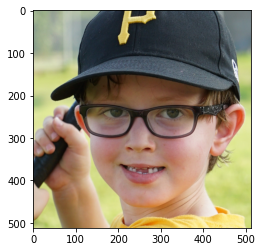

In [72]:
image_org = Image.open("tutorial/tuto_images/segmentation/original.png")
image_org = image_org.resize((512, 512), Image.BILINEAR)

plt.imshow(np.asarray(image_org))
plt.show()

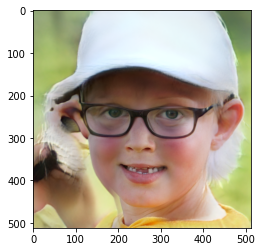

In [73]:
image = Image.open("tutorial/tuto_images/segmentation/transformed.png")
image = image.resize((512, 512), Image.BILINEAR)

plt.imshow(np.asarray(image))
plt.show()

**Segmentation**

In [74]:

def segmentation(images, net, device):
    """
    Classes Legend:
    ##### From Model #######
    ----- Background ------
    0: background

    --------- Eye ---------
    4: in the eye 1 (no if glasses)
    5: in the eye 2 (no if glasses)
    6: glasses

    -------- Nose ---------
    10: nose

    -------- Mouth --------
    11: inside of mouth
    12: upper lip
    13: lower lip

    -------- Hair ---------
    17: hair

    -------- Foreground ----
    16: clothes
    18: hat

    -------- Other --------
    1: back of face
    2: eyebrow 1
    3: eyebrow 2


    7: ear 1
    8: ear 2
    9: earrings

    14: neck
    15: necklace

    ###### NEW #######
    0: background
    1: eyes
    2: nose
    3: mouth
    4: hair
    5: foreground
    6: other
    """
    if images.ndim == 3:
        images = torch.unsqueeze(images, 0)
    images = images.to(device)
    with torch.no_grad():
        pred = net(images)[0]
    pred = pred.squeeze(0).cpu().numpy().argmax(0)
    # Set class label to negative value temporarily to avoid conflict
    # between old and new classes (background remains 0)
    lor = np.logical_or
    pred = np.where(lor(lor(pred == 4, pred == 5), pred == 6), -1, pred)
    pred = np.where(pred == 10, -2, pred)
    pred = np.where(lor(lor(pred == 11, pred == 12), pred == 13), -3, pred)
    pred = np.where(pred == 17, -4, pred)
    pred = np.where(lor(pred == 16, pred == 18), -5, pred)
    pred = np.where(pred > 0, -6, pred)  # set remaining classes to 'other'
    pred = - pred
    return pred

In [75]:
seg_org = segmentation(to_tensor(image_org), net, device)
seg = segmentation(to_tensor(image), net, device)

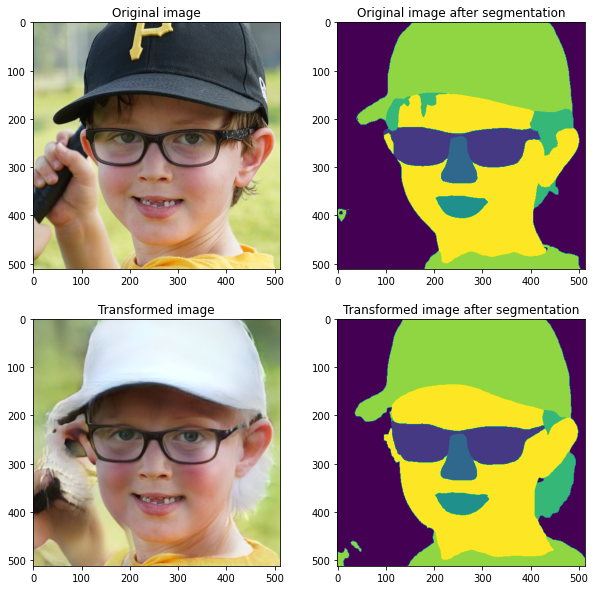

In [76]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(2, 2, 2)
plt.imshow(seg_org)
plt.title("Original image after segmentation")

plt.subplot(2, 2, 3)
plt.imshow(image)
plt.title("Transformed image")
plt.subplot(2, 2, 4)
plt.imshow(seg)
plt.title("Transformed image after segmentation")
plt.show()

In [77]:

def process_segmentation(seg, carac_name):
    """ Return a relevant segmentation depending on the current caracteristic.

    Prameters:
    ----------
    seg: np.ndarray
        Segmentation of the image (labels 0: background, 1: eyes,
        2: nose, 3: mouth, 4: hair, 5: hat, 6: other)
    carac_name: str
        Ident of the caracteristic ('Sk', 'A', 'Se', 'bald', ...)

    Returns:
    --------
    seg: np.ndarray or None
        New segmentation with 1 = pixel to keep in the original image
        and 0 = pixel to change with edited image. Return None if the
        caracteristic is not handled.
    """


    """
    Labels:
    0: background
    1: eyes
    2: nose
    3: mouth
    4: hair
    5: foreground
    6: other
    """
    if carac_name in {'Sk', 'A', 'Se', 'Ch'}:
        return np.where(seg != 0, 0, 1)
    elif carac_name in {'B', 'Hc', 'Hs'}:
        return np.where(seg == 4, 0, 1)
    elif carac_name in {'Pn', 'Bn'}:
        return np.where(seg == 2, 0, 1)
    elif carac_name == 'N':
        eyes = np.where(seg == 1, 1, 0).astype(np.uint8)
        kernel = np.ones((5, 5), 'uint8')
        eyes = cv2.dilate(eyes, kernel=kernel, iterations=1)
        return np.where(eyes == 1, 0, 1)
    elif carac_name == 'Be':
        eyes = np.where(seg == 1, 1, 0).astype(np.uint8)
        kernel = np.ones((5, 5), 'uint8')
        eyes = cv2.dilate(eyes, kernel=kernel, iterations=4)
        # under eye starts 10 pixels below the top of the eye
        under_eyes = np.where(eyes[:-30, :] == 1, 1, 0)
        rest = np.zeros((30, 512))
        under_eyes = np.concatenate((rest, under_eyes), axis=0)
        return np.where(under_eyes == 1, 0, 1)
    elif carac_name == 'Bp':
        return np.where(seg == 3, 0, 1)
    else:
        return None

In [78]:
carac_name = 'Hc'
seg_carac = process_segmentation(seg, carac_name)
seg_org_carac = process_segmentation(seg_org, carac_name)

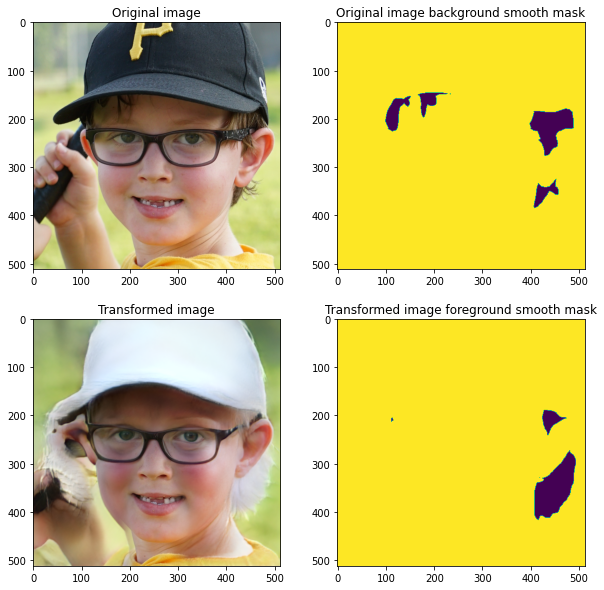

In [79]:

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(2, 2, 2)
plt.imshow(seg_org_carac)
plt.title("Original image background smooth mask")
plt.subplot(2, 2, 3)
plt.imshow(image)
plt.title("Transformed image")
plt.subplot(2, 2, 4)
plt.imshow(seg_carac)
plt.title("Transformed image foreground smooth mask")
plt.show()

In [80]:
def alpha_from_dist(dist, margin=21):
        return np.where(dist < margin, dist / margin, 1.0)

In [81]:


def merge_by_segmentation(img_org, seg_org, img, seg):
    seg_both = seg_org * seg
    dist = dist_edt(seg_both)
    alpha = alpha_from_dist(dist)[..., None]
    new_img = img_org * alpha + img * (1.0 - alpha)
    return new_img

In [82]:
# Merge the images continuously
image_final = merge_by_segmentation(image_org, seg_org_carac,
                                    image, seg_carac)


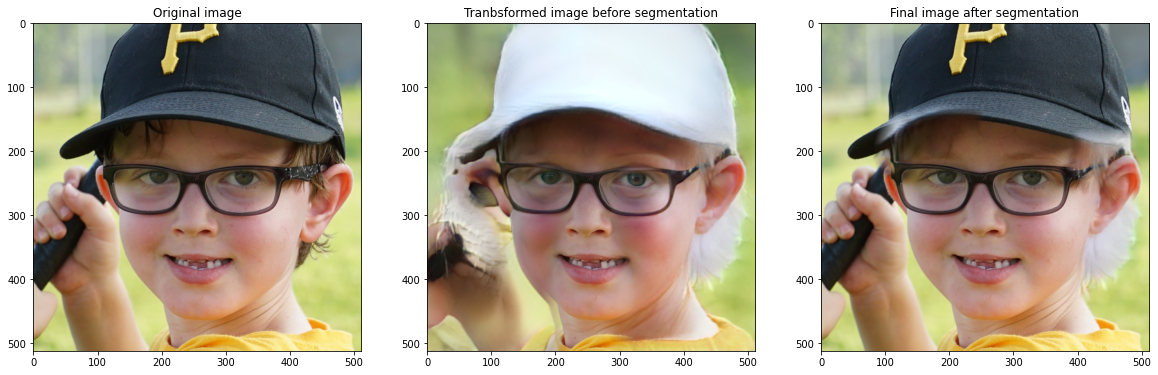

In [83]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("Tranbsformed image before segmentation")
plt.subplot(1, 3, 3)
plt.imshow(image_final.astype(np.uint8))
plt.title("Final image after segmentation")
plt.show()

In [84]:
def add_foreground(img, img_org, seg_org):
    foreground = np.where(seg_org == 5, 1, 0)
    dist = dist_edt(foreground)
    alpha = alpha_from_dist(dist, margin=6)[..., None]
    img = alpha * img_org + (1 - alpha) * img
    img = img.astype(np.uint8)
    # img = cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

In [85]:
# Add Foreground of the original image
image_final = add_foreground(image_final, image_org, seg_org)

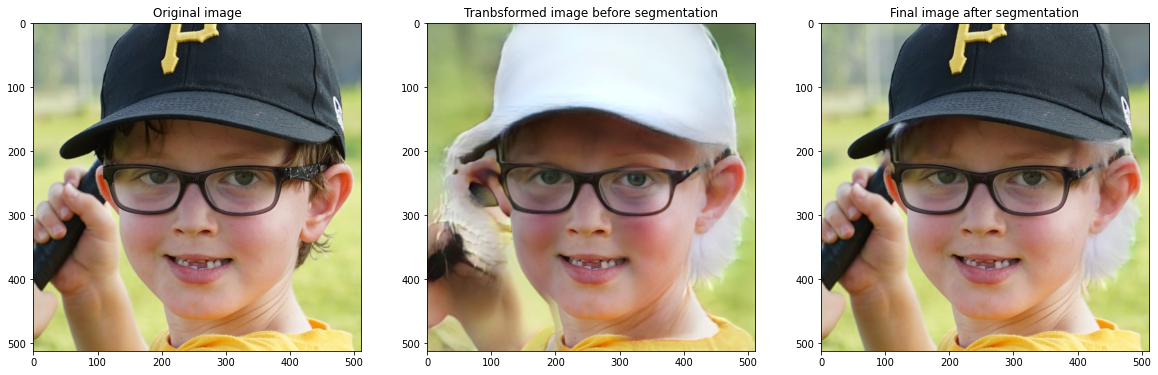

In [86]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.imshow(image_org)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(image)
plt.title("Tranbsformed image before segmentation")
plt.subplot(1, 3, 3)
plt.imshow(image_final)
plt.title("Final image after segmentation")
plt.show()